In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings("ignore")

# %matplotlib notebook
plt.style.use('ggplot')

# TP n°2 : Support Vector Machine (SVM)

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$


We have that the constraint which is $ \forall i, \xi_i \geq 0$ and $\xi_i \geq 1- y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )$. 
So $\xi_i \geq max(0, 1- y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 ) = [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ $. 

Thus, the primal problem can be rewritten as the expression above. 

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

In the sentence we say that we use a convex upper bound because all the function of the argmin are convex and $ x \mapsto [1-x]_+$ is a loss function. 

The difference between those losses are the fact that when $1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )$ is positive, the binary loss will return $1$ whereas the hinge loss will return the actual value of the loss. We can write a relation between those losses : $ BinaryLoss(z) = sgn(HingeLoss(z)-1)$.

The hinge loss is smoother than the Binary loss which can allow a certain of missclassification. (For instance if there is a point that is almost in the other side of the delimiter, we will know it thanks to the Hinge Loss).

## Example of using SVC (originally in ```svm_script.py```)

In [3]:
from matplotlib import rc
from matplotlib.colors import ListedColormap
import seaborn as sns

plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
# text.usetex is set as False by default to avoid problems with student computers
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

###############################################################################
#           Displaying labeled data
###############################################################################

symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=[color_blind_list[i]], s=80, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
              samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec.reshape(1, -1)) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

Score : 0.92


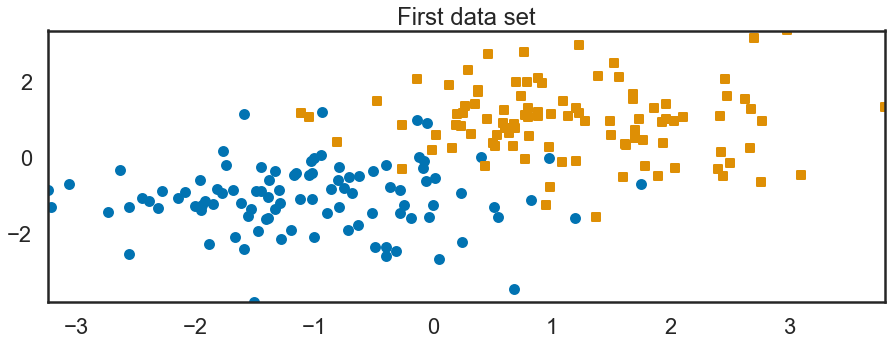

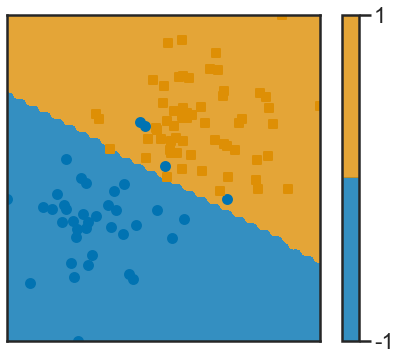

In [4]:
# This is an example of using SVC for data generated in the same way as the previous TP
n1 = 100
n2 = 100
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))
plt.title('First data set')
plot_2d(X1, y1)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score = clf.score(X_test, Y_test)
print('Score : %s' % score)
# display the frontiere


def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return clf.predict(xx.reshape(1, -1))

plt.figure(2)
frontiere(f, X_train, Y_train, w=None, step=50, alpha_choice=1)

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distrtibutions : each class is a Gaussian with specific parameters. This time, use the function make_blobs available in sklearn.datasets library. Reserve 75% of the data for training and 25% for the test data.

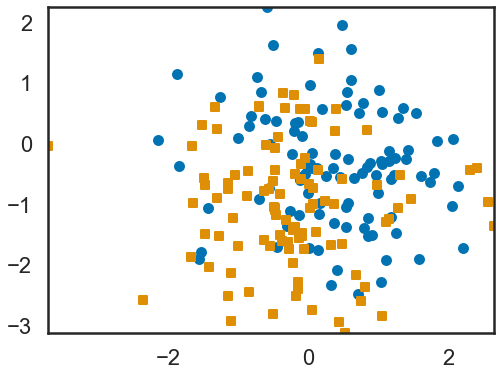

In [5]:
X,y = make_blobs(n_samples = 200,centers = 2, cluster_std = 1, center_box=(-1,1))
plot_2d(X,y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk.

In [7]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)

n= 1000
mu = [[-1,1], [2,2]]

c_1 = np.random.multivariate_normal(mu[0], np.eye(2), n//2)
c_2 = np.random.multivariate_normal(mu[1], np.eye(2), n//2)

C = np.concatenate((c_1,c_2), axis = 0)
mean_bayes = 0 

for c in C:
    proba_1 = multivariate_normal.pdf(c, mu[0], cov=np.eye(2))
    proba_2 = multivariate_normal.pdf(c, mu[1], cov=np.eye(2))
    bayes_risk = min(proba_1/(proba_1+proba_2), proba_2/(proba_1+proba_2))
    mean_bayes += 1/n*bayes_risk
    
print('The estimation of the Bayes Risk', mean_bayes)

The estimation of the Bayes Risk 0.05864675710813966


**5)** Draw the decision boundary H induced by SVM as well as the hyperplanes H1 and H−1. Vary the parameter C to see its impact on the number of support vectors. We can use the example https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

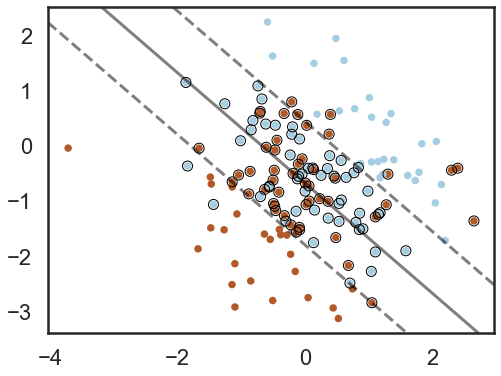

In [8]:
clf = svm.SVC(kernel= 'linear', C = 1000)
clf.fit(X_train,y_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()



 > C is the regularization parameter. The number of support vectors dicreases when C increases. 

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation to find the optimal parameter C∗ to classify this new dataset using a linear kernel.

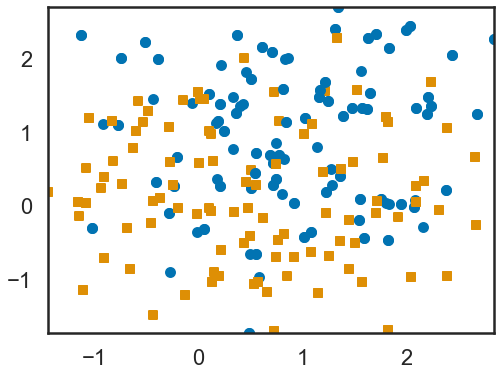

In [9]:
# Generate data and verify graphically that the two classes overlap
X_overlap,y_overlap = make_blobs(n_samples = 200,centers = 2, cluster_std = 1, center_box=(-1,1))
plot_2d(X_overlap,y_overlap)
X_train_overlap, X_test_overlap, y_train_overlap, y_test_overlap = train_test_split(X_overlap,y_overlap, test_size = 0.25)

plot_2d(X_train_overlap,y_train_overlap)

In [10]:
# Find the best working C with a 5-fold cross-validation


param_grid = {'C':np.arange(1,1000,1)}
clf_overlap = GridSearchCV(clf, param_grid, return_train_score=True)
clf_overlap.fit(X_train_overlap,y_train_overlap)
clf_overlap.best_params_ 
print('mean train score', np.mean(clf_overlap.cv_results_['mean_train_score']))
print('mean test score', np.mean(clf_overlap.cv_results_['mean_test_score']))

mean train score 0.6850250250250249
mean test score 0.6798932265598931


**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore gamma and C), can lead to overfitting.

In [11]:
# Vary the parameter of the kernel and check the difference between training and testing scores

clf_overlap_gauss = SVC(kernel = 'rbf')
param_gauss = {'C':np.arange(1,1000,1), 'gamma' : [0.5]}
clf_overlap_gauss = GridSearchCV(clf_overlap_gauss, param_gauss, return_train_score= True)
clf_overlap_gauss.fit(X_overlap,y_overlap)
mean_train = clf_overlap_gauss.cv_results_['mean_train_score']
mean_test = clf_overlap_gauss.cv_results_['mean_test_score']

print('difference between the mean testing and training score : ', np.mean(mean_train-mean_test))

difference between the mean testing and training score :  0.11612987987987988


> We see that we have a hudge difference between the mean_train and the mean_test which is a sign of overfitting

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function make_blobs available in sklearn.datasetslibrary ).

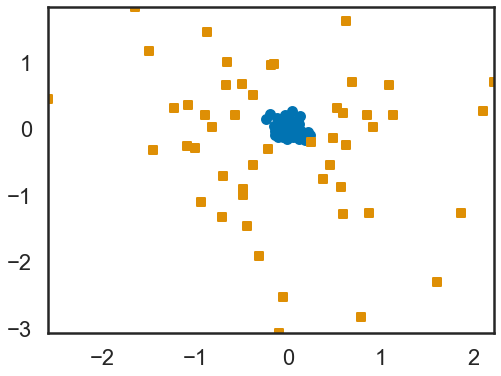

In [12]:
X_nl, y_nl = make_blobs(centers = 2, cluster_std= (0.1,1), center_box=(0,0))
plot_2d(X_nl, y_nl)

X_nl_train, X_nl_test, y_nl_train, y_nl_test = train_test_split(X_nl, y_nl, test_size = 0.25)

**9)** Use an SVM with a Gaussian kernel then a polynomial (with well-adapted parameters) then plot the decision boundaries of these algorithms on separate graphs.

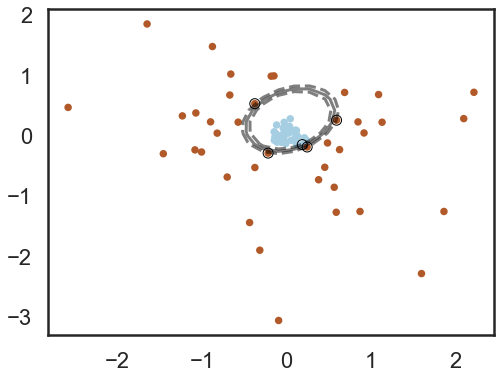

In [13]:
## Gaussian Kernel : 

clf = svm.SVC(kernel= 'rbf', C = 1000)
clf.fit(X_nl_train,y_nl_train)
plt.scatter(X_nl_train[:, 0], X_nl_train[:, 1], c=y_nl_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

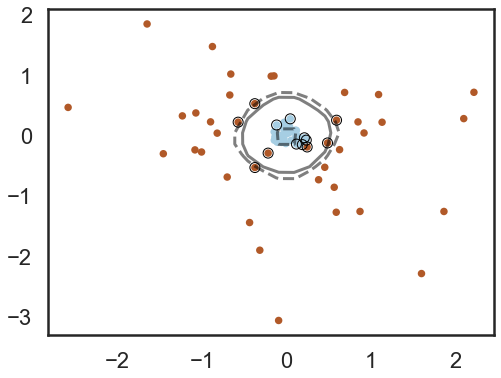

In [14]:
## Polynomial Kernel : 

clf_poly = svm.SVC(kernel= 'poly', C = 1000, degree=6)
clf_poly.fit(X_nl_train,y_nl_train)
plt.scatter(X_nl_train[:, 0], X_nl_train[:, 1], c=y_nl_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf_poly.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf_poly.support_vectors_[:, 0], clf_poly.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()



> We remark that if the degree given as a parameter for the polynomial kernel is odd the get something like a spiderweb and with an even number we get a delimiter that a circle/square.

**10)** We wish to compare classification performance between different SVMs based on different kernels
(linear, polynomial and Gaussian). Propose a method allowing to compare these three algorithms.

> To compare the three algorithms we can compare fore various values of C the score given by the three methods and we the one that has the highest average score.

**11)** Draw the learning curve of the algorithm : with fixed hyper-parameters and fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

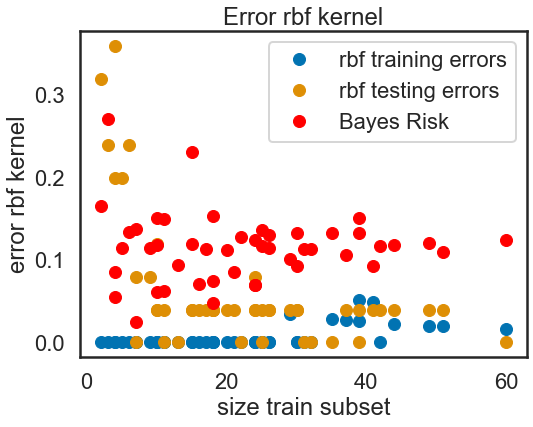

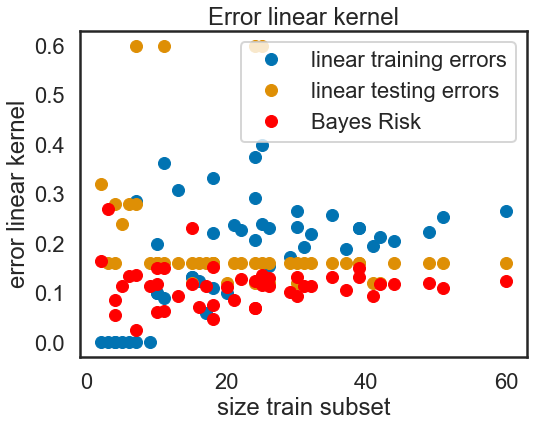

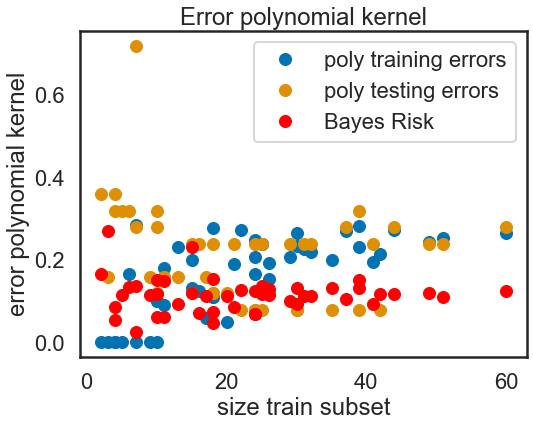

In [36]:
# Add this estimation to the plot of train/test error

# Hyper-parameters and fixed test set : 

clf_rbf = svm.SVC(kernel = 'rbf', C = 10)
clf_linear = svm.SVC(kernel = 'linear', C = 10)
clf_poly = svm.SVC(kernel = 'poly', C = 10)

train_size = X_nl_train.shape[0]
size_train_subset = []
training_errors_rbf, testing_errors_rbf = [],[]
training_errors_linear, testing_errors_linear = [],[]
training_errors_poly, testing_errors_poly = [],[]

for i in range(50):
    ## beginning and end such as we don't always start from the beginning of the dataset 
    beginning = np.random.randint(2,train_size-2)
    end = beginning + np.random.randint(2, train_size - beginning)
    X_sub_training, y_sub_training = X_nl[beginning:end], y_nl[beginning:end]
    if (y_sub_training==0).all() or (y_sub_training==1).all():
        continue 
    # On fit la data avec les sub_set générés précedemment
    clf_rbf.fit(X_sub_training, y_sub_training)
    clf_linear.fit(X_sub_training, y_sub_training)
    clf_poly.fit(X_sub_training, y_sub_training)
    training_error_rbf, testing_error_rbf = 1- clf_rbf.score(X_sub_training, y_sub_training), 1 - clf_rbf.score(X_nl_test, y_nl_test)
    training_errors_rbf.append(training_error_rbf), testing_errors_rbf.append(testing_error_rbf)
    training_error_linear, testing_error_linear = 1 - clf_linear.score(X_sub_training, y_sub_training), 1 - clf_linear.score(X_nl_test, y_nl_test)
    training_errors_linear.append(training_error_linear), testing_errors_linear.append(testing_error_linear)
    training_error_poly, testing_error_poly = 1 - clf_poly.score(X_sub_training, y_sub_training), 1-clf_poly.score(X_nl_test, y_nl_test)
    training_errors_poly.append(training_error_poly), testing_errors_poly.append(testing_error_poly)
    size_train_subset.append(end-beginning)

    
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# We do has in the previous question but this time we store the values of the bayes risk 

mu = [[0,0], [0,0]]

Bayes_risk_list = []

for size in size_train_subset:
    
    mean_bayes = 0
    c_1 = np.random.multivariate_normal(mu[0], np.eye(2), size//2)
    c_2 = np.random.multivariate_normal(mu[1], np.eye(2), size//2)
    C = np.concatenate((c_1,c_2), axis = 0)

    for c in C:
        proba_1 = multivariate_normal.pdf(c, mu[0], cov=0.1*np.eye(2))
        proba_2 = multivariate_normal.pdf(c, mu[1], cov=1*np.eye(2))
        bayes_risk = min(proba_1/(proba_1+proba_2), proba_2/(proba_1+proba_2))
        mean_bayes += 1/size*bayes_risk
                                        
    Bayes_risk_list.append(mean_bayes)
    

plt.plot(size_train_subset, training_errors_rbf,'o', label = 'rbf training errors')
plt.plot(size_train_subset, testing_errors_rbf,'o', label = 'rbf testing errors')
plt.plot(size_train_subset, Bayes_risk_list, 'o', color = 'r', label = 'Bayes Risk')
plt.xlabel('size train subset')
plt.ylabel('error rbf kernel')
plt.title('Error rbf kernel')
plt.legend()
plt.show()

plt.plot(size_train_subset, training_errors_linear, 'o', label = 'linear training errors')
plt.plot(size_train_subset, testing_errors_linear, 'o', label = 'linear testing errors')
plt.plot(size_train_subset, Bayes_risk_list, 'o', color = 'r', label = 'Bayes Risk')
plt.xlabel('size train subset')
plt.ylabel('error linear kernel')
plt.title('Error linear kernel')
plt.legend()
plt.show()

plt.plot(size_train_subset, training_errors_poly, 'o', label = 'poly training errors')
plt.plot(size_train_subset, testing_errors_poly, 'o', label = 'poly testing errors')
plt.plot(size_train_subset, Bayes_risk_list, 'o', color = 'r', label = 'Bayes Risk')
plt.xlabel('size train subset')
plt.ylabel('error polynomial kernel')
plt.title('Error polynomial kernel')
plt.legend()
plt.show()

> We remark that when the size of the train subset increases we have the bayes risk that decrease.

> Also we remark that the error is lower for the rbf Kernel in comparison with the other Kernels.

**12)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.


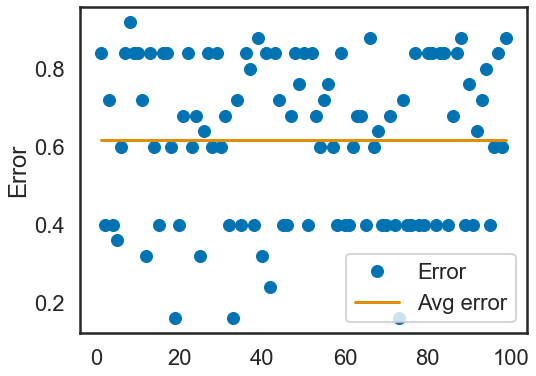

In [85]:
# modification of the training data 
from copy import deepcopy 
# nb_label is the number of labels we want to modify
nb_label = 30

noise_errors_list = []

for i in range(1,100):
    y_nl_noise_train = deepcopy(y_nl)
    labels_to_modify = [np.random.randint(1,len(X_nl)) for i in range(nb_label)]
    for label in labels_to_modify:
        #we invert the labels
        y_nl_noise_train[label] = 1 - y_nl[label]
    
    clf_noise = svm.SVC(kernel = 'linear')
    clf_noise.fit(X_nl,y_nl_noise_train)
    noise_errors_list.append(clf_noise.score(X_nl_test,y_nl_test))

plt.plot([i for i in range(1,100)], noise_errors_list, 'o', label = 'Error')
plt.plot([i for i in range(1,100)], [np.array(noise_errors_list).mean() for i in range(1,100)], label =  'Avg error')
plt.ylabel('Error')
plt.legend()
plt.show()


## SVM GUI

**13)** Start the script svm_gui.py available at the link : http://scikit-learn.org/stable/auto_examples/applications/svm_gui.html
This application allows real-time evaluation of the impact the choice of the kernel and the regula-
rization parameter C.

In [17]:
import svm_gui


Libsvm GUI

A simple graphical frontend for Libsvm mainly intended for didactic
purposes. You can create data points by point and click and visualize
the decision region induced by different kernels and parameter settings.

To create positive examples click the left mouse button; to create
negative examples click the right button.

If all examples are from the same class, it uses a one-class SVM.




**14)** Generate a very unbalanced data set with much more points in one class than in the other (at least
90% vs 10%)

> The data can be seen in the following pictures

**15)** Using a linear kernel and decreasing the parameter C what do you observe ?

We observe that when $C$ increases the separation line always goes more to the left 

> C = 10

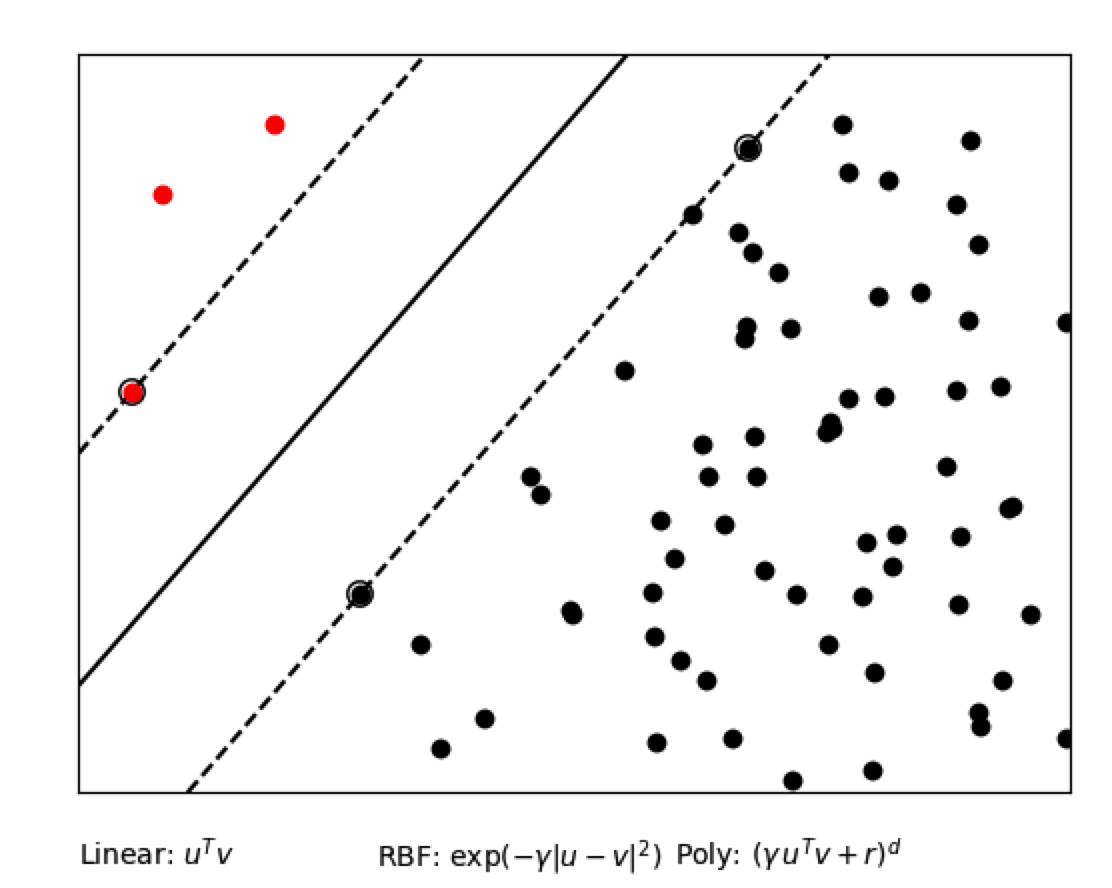

> C = 0.001

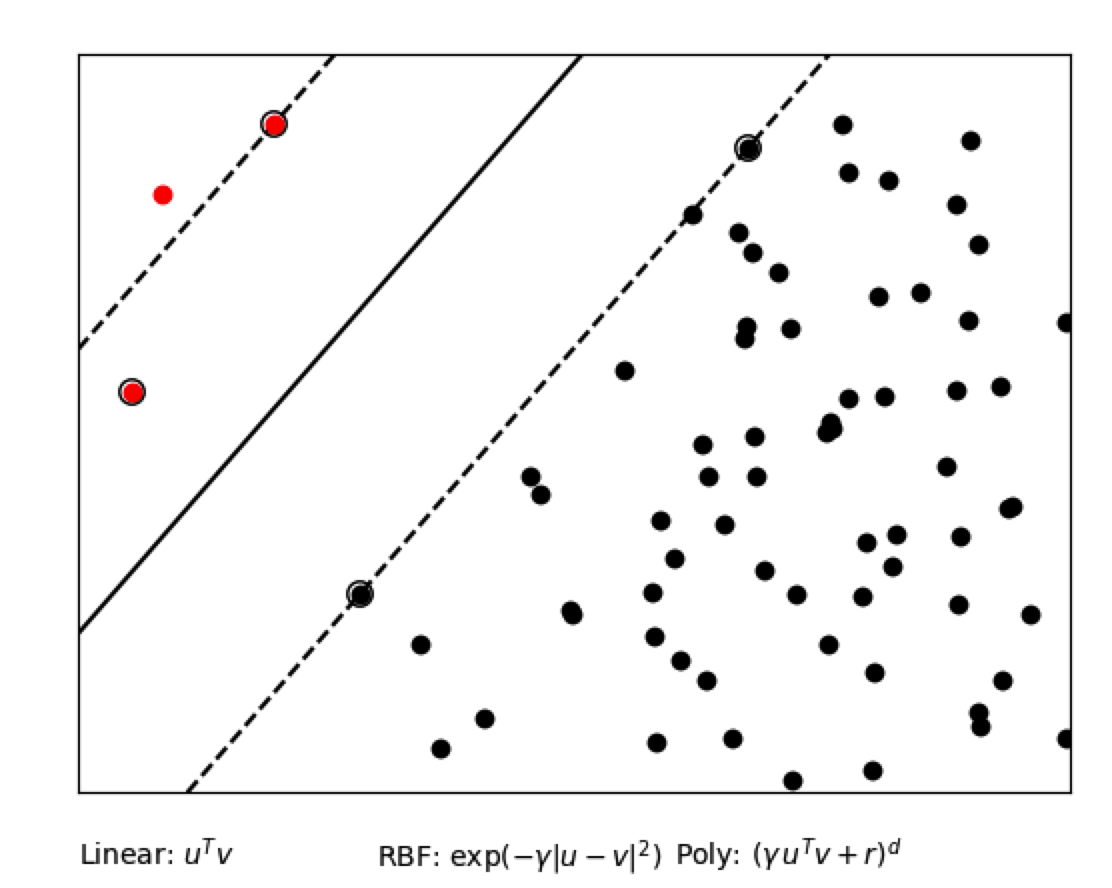

> C = 0.00001

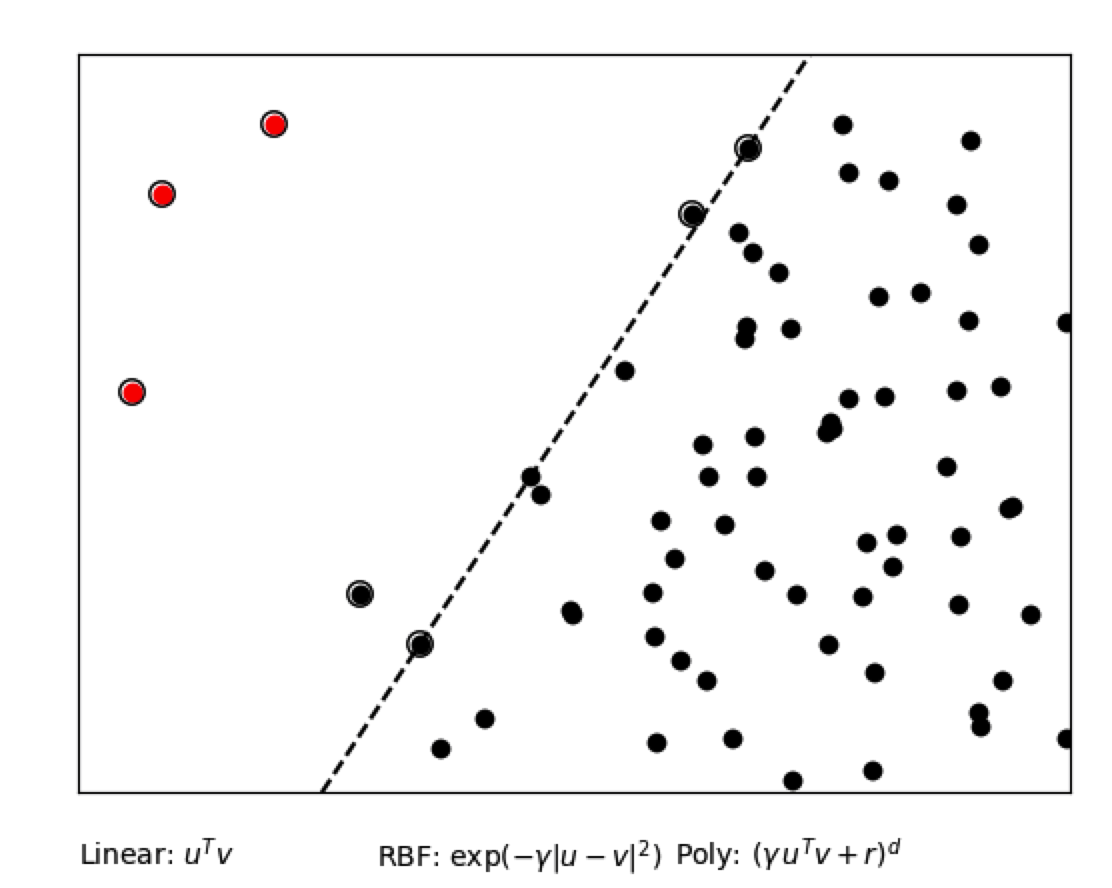

> When C decreases we can see that the separation line goes to the left side of the figure. It means that the red cluster is complitely dominated by the black cluster : they are on the same side of the demarcation line.

## Going further : application to face classification

Code for downloading and organizing the data:

In [87]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images / 255.
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**16)** By modifying the following code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of C on a logarithmic scale between 1e5 and 1e-5.

Fitting the classifier to the training set


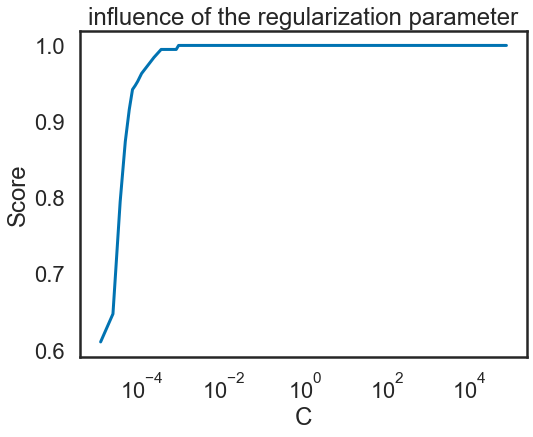

In [88]:
####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()
    
C_list = [a*10**b for b in range(-5,5) for a in range(1,9)]
score_list = []
for c in C_list:
    clf = svm.SVC(kernel="linear", C = c)
    clf.fit(X_train, y_train)
    score_list.append(clf.score(X_train, y_train))
    
plt.plot(C_list,score_list)
plt.xscale('log')
plt.ylabel('Score')
plt.xlabel('C')
plt.title("influence of the regularization parameter")
plt.show()

In [89]:
print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set
done in 0.322s
Chance level : 0.6210526315789474
Accuracy : 0.9052631578947369


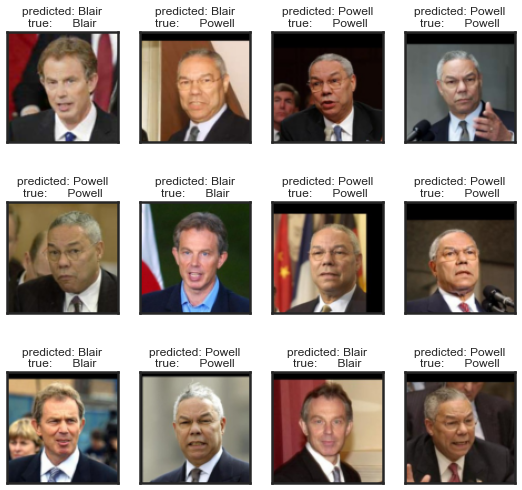

In [90]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**17)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

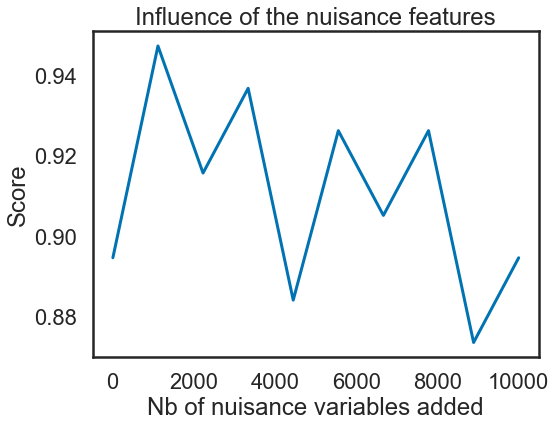

In [97]:
scores_pred = []
nb_nuisance = np.linspace(10,10000, 10, dtype='int')
for i in nb_nuisance:
    nuisance = np.random.normal(0,1, size=(n_samples, i))
    X_noise = np.insert(X, np.random.randint(0, 10000, i), nuisance, axis=1)
    
    X_noise_train, X_noise_test, y_noise_train, y_noise_test, images_noise_train, image_noise_test = train_test_split(X_noise, y, images, test_size=0.25)
    
    clf_noise = SVC(kernel='linear')
    clf_noise.fit(X_noise_train, y_noise_train)
    scores_pred.append(clf_noise.score(X_noise_test, y_noise_test))

plt.plot(nb_nuisance, scores_pred)
plt.xlabel('Nb of nuisance variables added')
plt.ylabel('Score')
plt.title('Influence of the nuisance features')
plt.show()

**18)** Explain why the features are centered and reduced.

 > We center and reduce the feature because the SVM is not scale invariant. 

**19)** What is the effect of choosing a non-linear RBF kernel on prediction? You will be able to improve the prediction with a reduction of dimension based on the object sklearn.decomposition.RandomizedPCA.

In [103]:
from sklearn.decomposition import PCA